Dallin Nielson\
DSC 530 - Data Exploration and Analysis\
Week 8 Exercises


# Exercises 9-1

As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use thinkstats2.SampleRows to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [1]:
import os
os.chdir(r'C:\Users\dalli\OneDrive\Documents\Education\DSC 530 - Data Exploration and Analysis\ThinkStats2\code')

import nsfg
import thinkstats2
import numpy as np

As a first step to solve this problem, I first need to recreate the custom subclasses of HypothesisTest objects that are not available within the `thinkstats2` module.

In [2]:
# Recreate the author's subclasses of HypothesisTest objects

class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys
    
    
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

Next, I create a function to perform the tests using varying numbers of sample sizes.

In [3]:
def RunTests(live_births_df, iters=1000):
    
    """
    Runs various tests on the live_births_df dataframe and returns a
    list with the results of those tests.
    """

    # Split the data into First and Other births
    firsts = live_births_df[live_births_df.birthord == 1]
    others = live_births_df[live_births_df.birthord != 1]

    # Run permutation tests for the mean prglngth of each group
    values = firsts['prglngth'].values, others['prglngth'].values
    hypothesis_test_1 = DiffMeansPermute(values)
    p_prglngth_mean = hypothesis_test_1.PValue(iters=iters)

    # Run permutation tests for the totalwgt_lb of each group
    values = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    hypothesis_test_2 = DiffMeansPermute(values)
    p_totalwgt_mean = hypothesis_test_2.PValue(iters=iters)

    # Run tests for the Correlation between agepreg and totalwgt_lb
    live_sans_na = live_births_df.dropna(subset=['agepreg', 'totalwgt_lb'])
    values = live_sans_na.agepreg.values, live_sans_na.totalwgt_lb.values
    hypothesis_test_3 = CorrelationPermute(values)
    p_corr = hypothesis_test_3.PValue(iters=iters)

    # Run tests for the Chi-squared metric of prglngth
    values = firsts.prglngth.values, others.prglngth.values
    hypothesis_test_4 = PregLengthTest(values)
    p_chi_squared = hypothesis_test_4.PValue(iters=iters)
    
    return [
        p_prglngth_mean,   # The p-value of the prglngth mean test
        p_totalwgt_mean,   # The p-value of the totalwgt mean test
        p_corr,            # the p-value of the correlation test
        p_chi_squared      # the p-value of the chi_squared test
    ]

Finally, I run the tests using several different sample sizes.

In [4]:
preg = nsfg.ReadFemPreg()
live_births = preg[preg['outcome']==1]

n = len(live_births)

results = [["Sample Size", "P (prglngth)", 'P (totalwgt)', 'P (correlation)', 'P (chi-squared)']]

for _ in range(7):
    sample = thinkstats2.SampleRows(live_births, n)
    result = [n] + RunTests(sample)
    results.append(result)
    n //= 2
    

In [5]:
for r in results:
    print(f"{r[0]:>11}{r[1]:>16}{r[2]:>16}{r[3]:>18}{r[4]:>18}")

Sample Size    P (prglngth)    P (totalwgt)   P (correlation)   P (chi-squared)
       9148           0.194             0.0               0.0               0.0
       4574           0.467             0.0               0.0               0.0
       2287           0.681           0.012               0.0             0.007
       1143           0.615           0.166              0.02             0.001
        571           0.792           0.239             0.455             0.137
        285           0.761           0.171              0.06             0.006
        142           0.355           0.328             0.096             0.191


With the exception of the P-value for the mean of `prglngth`, the P-Values seem to get bigger as the sample size decreases. A sample size around 2300 might be ok for the Correlation and Chi-Squared tests, but anything smaller seems to decrease the confidence we can have in the results.

# Exercises 10-1

#### 1. Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height.

In [6]:
import brfss
import thinkplot

# Create the dataframe
df = brfss.ReadBrfss(nrows=None).dropna(subset=['htm3', 'wtkg2'])

# Calculate the LeastSquares line
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)
y_intercept, slope = thinkstats2.LeastSquares(heights, log_weights)

print(f"Y intercept: {round(y_intercept,5):>9}")
print(f"Slope: {round(slope, 5):>15}")

Y intercept:   0.99308
Slope:         0.00528


#### 2. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed?

Because it's not usually intuitive for people to understand data in a logarthmic format, it would be best to convert the `weights` back to normal kilograms. We can superimpose the line of least squares, which remains in logarithmic, over the data points on a scatterplot to visualize the non-linear relationship between height and width:

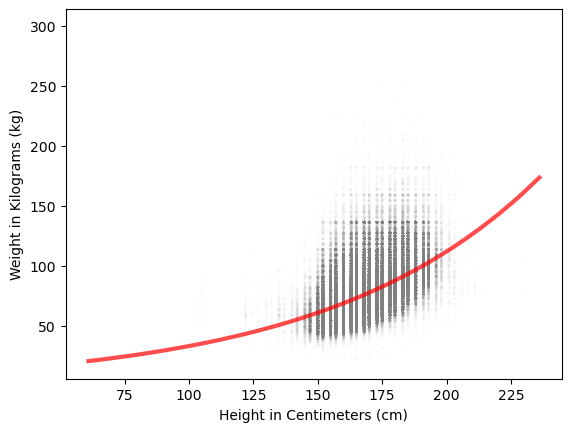

In [7]:
# Create a scatterplot of weight vs. height.
thinkplot.Scatter(heights, weights, alpha=0.01, s=5, color='grey')
x, y = thinkstats2.FitLine(heights, y_intercept, slope)
thinkplot.Plot(x, 10**y, color='red')
thinkplot.Config(xlabel='Height in Centimeters (cm)', 
                 ylabel='Weight in Kilograms (kg)', legend=False
                )

#### 3. If you were trying to guess someone’s weight, how much would it help to know their height?

Judging from the previous visual, it appears that knowing someone's height would improve your guesses of people's weight as opposed to just using random chance.

#### 4. Use resampling, with and without weights (totalwt), to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. 

In [9]:
from thinkstats2 import Mean, ResampleRows, ResampleRowsWeighted, Std

def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    std = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print(f"Mean: {mean} \nStandard Error: {std} \nConfidence Interval: {ci}")

# Resample the data without weights
unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
print("Unweighted sample")
Summarize(unweighted)

# Resample the data with weigths
weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
print("\nWeighted sample")
Summarize(weighted)

Unweighted sample
Mean: 168.95466306412825 
Standard Error: 0.0141877515178842 
Confidence Interval: (168.93053618706926, 168.97800834697549)

Weighted sample
Mean: 170.49677982073206 
Standard Error: 0.0175945190287072 
Confidence Interval: (170.4656217789365, 170.5217061783787)


#### 5. How much does correct weighting affect the estimates?
The weighting results in a higher mean, a larger error margin, and a higher confidence interval. 